In [2]:
# import necessary libraries
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import brown
from nltk.corpus import treebank
from nltk.corpus import conll2000

from gensim.models import KeyedVectors

from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.models import Sequential

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [3]:
# load POS tagged corpora from NLTK
treebank_corpus = treebank.tagged_sents(tagset='universal')
brown_corpus = brown.tagged_sents(tagset='universal')
conll_corpus = conll2000.tagged_sents(tagset='universal')
tagged_sentences = treebank_corpus + brown_corpus + conll_corpus

In [4]:
tagged_sentences[11]

[('``', '.'),
 ('We', 'PRON'),
 ('have', 'VERB'),
 ('no', 'DET'),
 ('useful', 'ADJ'),
 ('information', 'NOUN'),
 ('on', 'ADP'),
 ('whether', 'ADP'),
 ('users', 'NOUN'),
 ('are', 'VERB'),
 ('at', 'ADP'),
 ('risk', 'NOUN'),
 (',', '.'),
 ("''", '.'),
 ('said', 'VERB'),
 ('*T*-1', 'X'),
 ('James', 'NOUN'),
 ('A.', 'NOUN'),
 ('Talcott', 'NOUN'),
 ('of', 'ADP'),
 ('Boston', 'NOUN'),
 ("'s", 'PRT'),
 ('Dana-Farber', 'NOUN'),
 ('Cancer', 'NOUN'),
 ('Institute', 'NOUN'),
 ('.', '.')]

In [121]:
X = [] # store input sequence
Y = [] # store output sequence

for sentence in tagged_sentences:
    X_sentence = []
    Y_sentence = []
    for entity in sentence:         
        X_sentence.append(entity[0])  # entity[0] contains the word
        Y_sentence.append(entity[1])  # entity[1] contains corresponding tag
        
    X.append(X_sentence)
    Y.append(Y_sentence)

In [6]:
num_words = len(set([word.lower() for sentence in X for word in sentence]))
num_tags   = len(set([word.lower() for sentence in Y for word in sentence]))

In [7]:
print("Total number of tagged sentences: {}".format(len(X)))
print("Vocabulary size: {}".format(num_words))
print("Total number of tags: {}".format(num_tags))

Total number of tagged sentences: 72202
Vocabulary size: 59448
Total number of tags: 12


In [8]:
set([word.lower() for sentence in Y for word in sentence])

{'.',
 'adj',
 'adp',
 'adv',
 'conj',
 'det',
 'noun',
 'num',
 'pron',
 'prt',
 'verb',
 'x'}

In [122]:
X

[['Pierre',
  'Vinken',
  ',',
  '61',
  'years',
  'old',
  ',',
  'will',
  'join',
  'the',
  'board',
  'as',
  'a',
  'nonexecutive',
  'director',
  'Nov.',
  '29',
  '.'],
 ['Mr.',
  'Vinken',
  'is',
  'chairman',
  'of',
  'Elsevier',
  'N.V.',
  ',',
  'the',
  'Dutch',
  'publishing',
  'group',
  '.'],
 ['Rudolph',
  'Agnew',
  ',',
  '55',
  'years',
  'old',
  'and',
  'former',
  'chairman',
  'of',
  'Consolidated',
  'Gold',
  'Fields',
  'PLC',
  ',',
  'was',
  'named',
  '*-1',
  'a',
  'nonexecutive',
  'director',
  'of',
  'this',
  'British',
  'industrial',
  'conglomerate',
  '.'],
 ['A',
  'form',
  'of',
  'asbestos',
  'once',
  'used',
  '*',
  '*',
  'to',
  'make',
  'Kent',
  'cigarette',
  'filters',
  'has',
  'caused',
  'a',
  'high',
  'percentage',
  'of',
  'cancer',
  'deaths',
  'among',
  'a',
  'group',
  'of',
  'workers',
  'exposed',
  '*',
  'to',
  'it',
  'more',
  'than',
  '30',
  'years',
  'ago',
  ',',
  'researchers',
  'reported'

In [ ]:
# let's look at first data point
# this is one data point that will be fed to the RNN



In [123]:
print('sample X: ', X[0], '\n')
print('sample Y: ', Y[0], '\n')

sample X:  ['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.'] 

sample Y:  ['NOUN', 'NOUN', '.', 'NUM', 'NOUN', 'ADJ', '.', 'VERB', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'NOUN', 'NUM', '.'] 



In [10]:
# In this many-to-many problem, the length of each input and output sequence must be the same.
# Since each word is tagged, it's important to make sure that the length of input sequence equals the output sequence
print("Length of first input sequence  : {}".format(len(X[0])))
print("Length of first output sequence : {}".format(len(Y[0])))

Length of first input sequence  : 18
Length of first output sequence : 18


In [124]:
# encode X
word_tokenizer = Tokenizer()                   
word_tokenizer.fit_on_texts(X) 
word_index = word_tokenizer.word_index
word_index

X_encoded = word_tokenizer.texts_to_sequences(X)

In [125]:
# encode Y
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(Y)
tag_index = tag_tokenizer.word_index
tag_index

Y_encoded = tag_tokenizer.texts_to_sequences(Y)

In [13]:
tag_index

{'noun': 1,
 'verb': 2,
 '.': 3,
 'adp': 4,
 'det': 5,
 'adj': 6,
 'adv': 7,
 'pron': 8,
 'conj': 9,
 'prt': 10,
 'num': 11,
 'x': 12}

In [126]:
print("** Raw data point **", "\n", "-"*100, "\n")
print('X: ', X[0], '\n')
print('Y: ', Y[0], '\n')
print()
print("** Encoded data point **", "\n", "-"*100, "\n")
print('X: ', X_encoded[0], '\n')
print('Y: ', Y_encoded[0], '\n')

** Raw data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  ['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.'] 

Y:  ['NOUN', 'NOUN', '.', 'NUM', 'NOUN', 'ADJ', '.', 'VERB', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'NOUN', 'NUM', '.'] 


** Encoded data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  [6423, 24231, 2, 7652, 102, 170, 2, 47, 1898, 1, 269, 17, 7, 13230, 619, 1711, 2761, 3] 

Y:  [1, 1, 3, 11, 1, 6, 3, 2, 2, 5, 1, 4, 5, 6, 1, 1, 11, 3] 



In [15]:
# make sure that each sequence of input and output are of same length

different_length = [1 if len(input) != len(output) else 0 for input, output in zip(X_encoded, Y_encoded)]
print("{} sentences have disparate input-output lengths.".format(sum(different_length)))

0 sentences have disparate input-output lengths.


### PAD SEQUENCES

In [16]:
# checking length of longest sentence
lengths = [len(seq) for seq in X_encoded]
print("Length of longest sentence: {}".format(max(lengths)))

Length of longest sentence: 271


<AxesSubplot:>

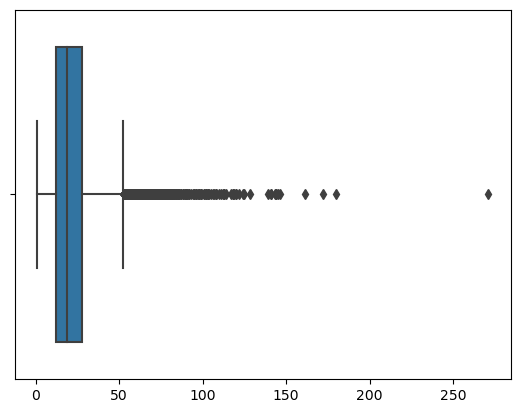

In [17]:
sns.boxplot(lengths)

In [127]:
MAX_SEQ_LENGTH = 100 

X_padded = pad_sequences(X_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
Y_padded = pad_sequences(Y_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

In [145]:
X_padded[11]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,    12,    51,    32,    67,  2218,   361,    19,
         345,  5065,    28,    22,  1190,     2,    14,    39,   163,
         816,   964, 16831,     4,  1433,    48, 32832,  2358,  1481,
           3])

RNN will learn the zero to zero mapping while training. So we don't need to worry about the padded zeroes. Please note that zero is not reserved for any word or tag, it's only reserved for padding.

In [20]:
X, Y = X_padded, Y_padded

In [21]:
word_index

{'the': 1,
 ',': 2,
 '.': 3,
 'of': 4,
 'and': 5,
 'to': 6,
 'a': 7,
 'in': 8,
 'that': 9,
 'for': 10,
 'is': 11,
 '``': 12,
 'was': 13,
 "''": 14,
 'it': 15,
 'he': 16,
 'as': 17,
 'with': 18,
 'on': 19,
 'be': 20,
 'his': 21,
 'at': 22,
 'by': 23,
 'from': 24,
 ';': 25,
 'this': 26,
 'had': 27,
 'are': 28,
 'i': 29,
 'but': 30,
 'or': 31,
 'have': 32,
 'not': 33,
 'an': 34,
 '?': 35,
 'they': 36,
 'which': 37,
 '--': 38,
 'said': 39,
 'were': 40,
 'one': 41,
 'has': 42,
 'you': 43,
 'would': 44,
 'all': 45,
 'their': 46,
 'will': 47,
 "'s": 48,
 'her': 49,
 'its': 50,
 'we': 51,
 'there': 52,
 'been': 53,
 'she': 54,
 'more': 55,
 'who': 56,
 '$': 57,
 'when': 58,
 'him': 59,
 'if': 60,
 'new': 61,
 'about': 62,
 'up': 63,
 'out': 64,
 ')': 65,
 '(': 66,
 'no': 67,
 'than': 68,
 ':': 69,
 'so': 70,
 'other': 71,
 'mr.': 72,
 'some': 73,
 'what': 74,
 'into': 75,
 'can': 76,
 'only': 77,
 'them': 78,
 'could': 79,
 '%': 80,
 'time': 81,
 'million': 82,
 'two': 83,
 'these': 84,
 'firs

In [22]:
last_value = list(word_index.items())[-1]
print(last_value)  

('synergies', 59448)


In [23]:
# word2vec
path = r'C:\Users\TEJKIRAN\GoogleNews-vectors-negative300.bin'

# load word2vec using the following function present in the gensim library
word2vec = KeyedVectors.load_word2vec_format(path, binary=True)

In [24]:
# word2vec effectiveness
word2vec.most_similar(positive = ["usa", "delhi"], negative = ["washington"])

[('india', 0.5653906464576721),
 ('jaipur', 0.52699875831604),
 ('chennai', 0.5198445916175842),
 ('kerala', 0.4849949777126312),
 ('mumbai', 0.48329898715019226),
 ('pune', 0.48062631487846375),
 ('bombay', 0.47675761580467224),
 ('punjab', 0.47532984614372253),
 ('zealand', 0.4694822430610657),
 ('rahul', 0.4684939384460449)]

In [25]:
word2vec.doesnt_match('love sex family beautiful'.split())

'sex'

In [26]:
word2vec.similarity("doll","toy")

0.6188484

The embeddings are weights of the Embedding layer in the model. The weights matrix is of shape <b>(vocab_size, embedding_dimension)</b>

In [27]:
EMBEDDING_SIZE  = 300  
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1

# create an empty embedding matix
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))

# copy vectors from word2vec model to the words present in corpus
for word, index in word_index.items():
    try:
        embedding_weights[index, :] = word2vec[word]
    except KeyError:
        pass

In [28]:
embedding_weights.shape

(59449, 300)

In [29]:
embedding_weights[1].shape

(300,)

In [30]:
Y = to_categorical(Y)

In [31]:
Y.shape

(72202, 100, 13)

In [69]:
Y

array([[[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [32]:
X.shape

(72202, 100)

In [33]:
# split entire data into training and testing sets
TEST_SIZE = 0.15
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=4)

In [34]:
# split training data into training and validation sets
VALID_SIZE = 0.15
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=VALID_SIZE, random_state=4)

In [35]:
# print number of samples in each set
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(X_train.shape))
print('Shape of output sequences: {}'.format(Y_train.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(X_validation.shape))
print('Shape of output sequences: {}'.format(Y_validation.shape))
print("-"*50)
print("TESTING DATA")
print('Shape of input sequences: {}'.format(X_test.shape))
print('Shape of output sequences: {}'.format(Y_test.shape))

TRAINING DATA
Shape of input sequences: (52165, 100)
Shape of output sequences: (52165, 100, 13)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences: (9206, 100)
Shape of output sequences: (9206, 100, 13)
--------------------------------------------------
TESTING DATA
Shape of input sequences: (10831, 100)
Shape of output sequences: (10831, 100, 13)


Now, there can be various variations in the shape that you use to feed an RNN depending on the type of architecture. Since the problem we're working on has a many-to-many architecture, the input and the output both include number of timesteps which is nothing but the sequence length. But notice that the tensor X doesn't have the third dimension, that is, number of features. That's because we're going to use word embeddings before feeding in the data to an RNN, and hence there is no need to explicitly mention the third dimension. That's because when you use the Embedding() layer in Keras, you the training data will automatically be converted to (#samples, #timesteps, #features) where #features will be the embedding dimention (and note that the Embedding layer is always the very first layer of an RNN). While using the embedding layer we only need to reshape the data to (#samples, #timesteps) which is what we have done. However, note that you'll need to shape it to (#samples, #timesteps, #features) in case you don't use the Embedding() layer in Keras.

## Vanilla RNN

<b>Uninitialised fixed embeddings</b><br>
First let's try running a vanilla RNN. For this RNN we won't use the pre-trained word embeddings. We'll use randomly inititalised embeddings. Moreover, we won't update the embeddings weights.

In [36]:
# total number of tags
NUM_CLASSES = Y.shape[2]

In [37]:
NUM_CLASSES

13

In [38]:
rnn_model = Sequential()
rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE, # vocabulary size - number of unique words in data        
                        output_dim    =  EMBEDDING_SIZE,  # length of vector with which each word is represented        
                        input_length  =  MAX_SEQ_LENGTH,  # length of input sequence        
                        trainable     =  False            # False - don't update the embeddings        
))

rnn_model.add(SimpleRNN(64, 
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
                                     #to access the hidden state output for each input time step
))
# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [39]:
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          17834700  
                                                                 
 simple_rnn (SimpleRNN)      (None, 100, 64)           23360     
                                                                 
 time_distributed (TimeDistr  (None, 100, 13)          845       
 ibuted)                                                         
                                                                 
Total params: 17,858,905
Trainable params: 24,205
Non-trainable params: 17,834,700
_________________________________________________________________


In [40]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [41]:
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
408/408 [==============================] - 58s 137ms/step - loss: 0.4863 - acc: 0.8575 - val_loss: 0.3298 - val_acc: 0.8995
Epoch 2/10
408/408 [==============================] - 58s 142ms/step - loss: 0.2728 - acc: 0.9165 - val_loss: 0.2298 - val_acc: 0.9280
Epoch 3/10
408/408 [==============================] - 57s 139ms/step - loss: 0.2078 - acc: 0.9353 - val_loss: 0.1862 - val_acc: 0.9411
Epoch 4/10
408/408 [==============================] - 57s 140ms/step - loss: 0.1747 - acc: 0.9447 - val_loss: 0.1619 - val_acc: 0.9483
Epoch 5/10
408/408 [==============================] - 56s 138ms/step - loss: 0.1556 - acc: 0.9502 - val_loss: 0.1473 - val_acc: 0.9521
Epoch 6/10
408/408 [==============================] - 57s 139ms/step - loss: 0.1438 - acc: 0.9534 - val_loss: 0.1380 - val_acc: 0.9548
Epoch 7/10
408/408 [==============================] - 55s 135ms/step - loss: 0.1362 - acc: 0.9553 - val_loss: 0.1318 - val_acc: 0.9564
Epoch 8/10
408/408 [==============================] - 5

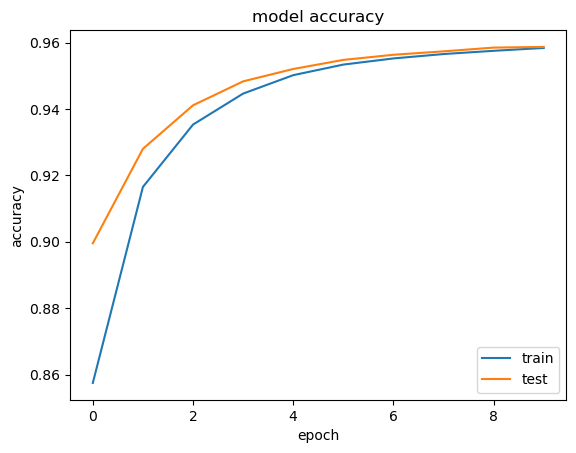

In [42]:
# visualise training history
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

### Uninitialised trainable embeddings

In [43]:
rnn_train_model = Sequential()
rnn_train_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         
                        output_dim    =  EMBEDDING_SIZE,          
                        input_length  =  MAX_SEQ_LENGTH,          
                        trainable     =  True                     # True - update the embeddings while training
))

rnn_train_model.add(SimpleRNN(64, 
              return_sequences=True  
))

rnn_train_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [44]:
rnn_train_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [45]:
rnn_train_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          17834700  
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100, 64)           23360     
                                                                 
 time_distributed_1 (TimeDis  (None, 100, 13)          845       
 tributed)                                                       
                                                                 
Total params: 17,858,905
Trainable params: 17,858,905
Non-trainable params: 0
_________________________________________________________________


In [46]:
rnn_training_true = rnn_train_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
408/408 [==============================] - 180s 432ms/step - loss: 0.2178 - acc: 0.9503 - val_loss: 0.0422 - val_acc: 0.9877
Epoch 2/10
408/408 [==============================] - 178s 437ms/step - loss: 0.0301 - acc: 0.9904 - val_loss: 0.0297 - val_acc: 0.9898
Epoch 3/10
408/408 [==============================] - 177s 435ms/step - loss: 0.0207 - acc: 0.9928 - val_loss: 0.0274 - val_acc: 0.9903
Epoch 4/10
408/408 [==============================] - 193s 473ms/step - loss: 0.0171 - acc: 0.9940 - val_loss: 0.0269 - val_acc: 0.9905
Epoch 5/10
408/408 [==============================] - 188s 460ms/step - loss: 0.0147 - acc: 0.9948 - val_loss: 0.0274 - val_acc: 0.9904
Epoch 6/10
408/408 [==============================] - 180s 442ms/step - loss: 0.0126 - acc: 0.9956 - val_loss: 0.0285 - val_acc: 0.9903
Epoch 7/10
408/408 [==============================] - 185s 454ms/step - loss: 0.0108 - acc: 0.9963 - val_loss: 0.0300 - val_acc: 0.9901
Epoch 8/10
408/408 [============================

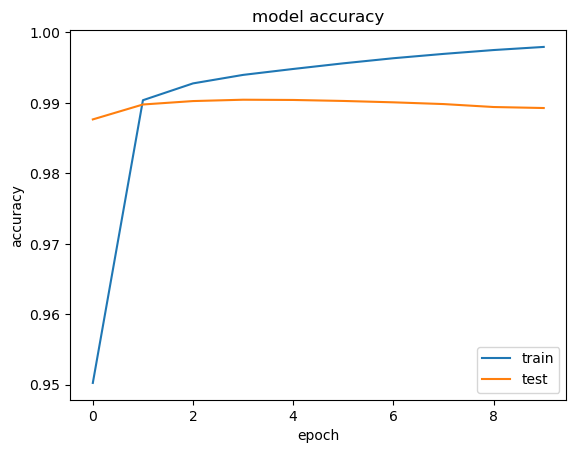

In [47]:
plt.plot(rnn_training_true.history['acc'])
plt.plot(rnn_training_true.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

### Using pre-trained embedding weights

In [48]:
rnn_model_weights = Sequential()

rnn_model_weights.add(Embedding(input_dim     =  VOCABULARY_SIZE,         
                        output_dim    =  EMBEDDING_SIZE,          
                        input_length  =  MAX_SEQ_LENGTH,          
                        weights       = [embedding_weights],      # word embedding matrix
                        trainable     =  True                     # True - update the embeddings while training
))

# add an RNN layer which contains 64 RNN cells
rnn_model_weights.add(SimpleRNN(64, 
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
rnn_model_weights.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [49]:
#embedding dimension
print("Embeddings shape: {}".format(embedding_weights.shape))

Embeddings shape: (59449, 300)


In [50]:
rnn_model_weights.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [51]:
rnn_model_weights.summary()

# (vocab_size*dimension) = 59449*300=17834700
# (num_features + num_units)* num_units + biases = (300 + 64)*64 + 64 =23360
# output_size * (input_size + 1) = 13*(64+1) = 845

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 300)          17834700  
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 100, 64)           23360     
                                                                 
 time_distributed_2 (TimeDis  (None, 100, 13)          845       
 tributed)                                                       
                                                                 
Total params: 17,858,905
Trainable params: 17,858,905
Non-trainable params: 0
_________________________________________________________________


In [52]:
rnn_training_weights = rnn_model_weights.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
408/408 [==============================] - 179s 432ms/step - loss: 0.1818 - acc: 0.9610 - val_loss: 0.0355 - val_acc: 0.9889
Epoch 2/10
408/408 [==============================] - 171s 418ms/step - loss: 0.0269 - acc: 0.9911 - val_loss: 0.0273 - val_acc: 0.9906
Epoch 3/10
408/408 [==============================] - 140s 343ms/step - loss: 0.0197 - acc: 0.9930 - val_loss: 0.0255 - val_acc: 0.9910
Epoch 4/10
408/408 [==============================] - 140s 344ms/step - loss: 0.0167 - acc: 0.9940 - val_loss: 0.0251 - val_acc: 0.9911
Epoch 5/10
408/408 [==============================] - 141s 345ms/step - loss: 0.0147 - acc: 0.9948 - val_loss: 0.0253 - val_acc: 0.9912
Epoch 6/10
408/408 [==============================] - 137s 336ms/step - loss: 0.0129 - acc: 0.9954 - val_loss: 0.0259 - val_acc: 0.9911
Epoch 7/10
408/408 [==============================] - 138s 338ms/step - loss: 0.0112 - acc: 0.9961 - val_loss: 0.0268 - val_acc: 0.9909
Epoch 8/10
408/408 [============================

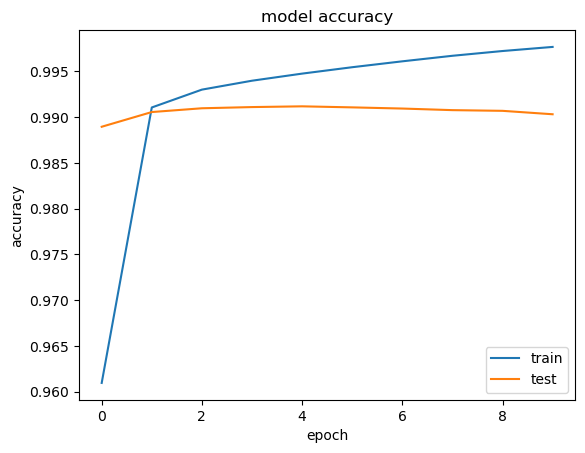

In [53]:
# visualise training history
plt.plot(rnn_training_weights.history['acc'])
plt.plot(rnn_training_weights.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

## LSTM

In [54]:
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim     = VOCABULARY_SIZE,         
                         output_dim    = EMBEDDING_SIZE,          
                         input_length  = MAX_SEQ_LENGTH,          
                         weights       = [embedding_weights],     
                         trainable     = True                     
))
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [55]:
lstm_model.compile(loss      =  'categorical_crossentropy',
                   optimizer =  'adam',
                   metrics   =  ['acc'])

In [56]:
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 300)          17834700  
                                                                 
 lstm (LSTM)                 (None, 100, 64)           93440     
                                                                 
 time_distributed_3 (TimeDis  (None, 100, 13)          845       
 tributed)                                                       
                                                                 
Total params: 17,928,985
Trainable params: 17,928,985
Non-trainable params: 0
_________________________________________________________________


In [57]:
lstm_training = lstm_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
408/408 [==============================] - 160s 387ms/step - loss: 0.3071 - acc: 0.9328 - val_loss: 0.0497 - val_acc: 0.9867
Epoch 2/10
408/408 [==============================] - 158s 387ms/step - loss: 0.0353 - acc: 0.9895 - val_loss: 0.0307 - val_acc: 0.9898
Epoch 3/10
408/408 [==============================] - 167s 409ms/step - loss: 0.0243 - acc: 0.9916 - val_loss: 0.0269 - val_acc: 0.9906
Epoch 4/10
408/408 [==============================] - 159s 389ms/step - loss: 0.0205 - acc: 0.9926 - val_loss: 0.0255 - val_acc: 0.9909
Epoch 5/10
408/408 [==============================] - 159s 389ms/step - loss: 0.0183 - acc: 0.9933 - val_loss: 0.0247 - val_acc: 0.9912
Epoch 6/10
408/408 [==============================] - 164s 402ms/step - loss: 0.0167 - acc: 0.9939 - val_loss: 0.0245 - val_acc: 0.9913
Epoch 7/10
408/408 [==============================] - 165s 404ms/step - loss: 0.0153 - acc: 0.9944 - val_loss: 0.0243 - val_acc: 0.9915
Epoch 8/10
408/408 [============================

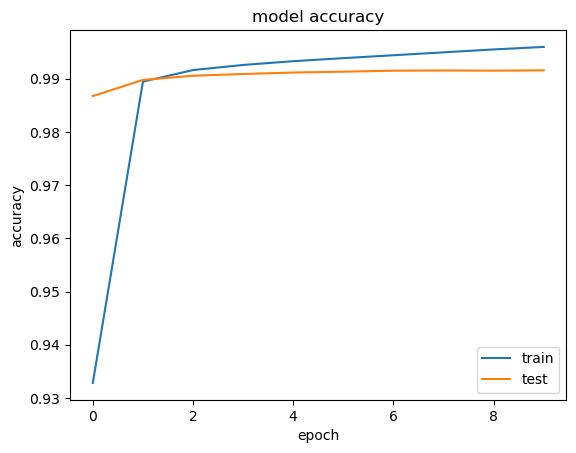

In [58]:
plt.plot(lstm_training.history['acc'])
plt.plot(lstm_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

## Now It's Prediction Time......

In [175]:
test_sentences = "The value of a human being is within himself"
token_list = word_tokenizer.texts_to_sequences([test_sentences])[0]
token_list = pad_sequences([token_list], maxlen=MAX_SEQ_LENGTH, padding='pre', truncating="post")
predicted_pos_tags_indices = np.argmax(lstm_model.predict(token_list), axis=-1)

# Convert the indices to POS tags
predicted_pos_tags = []
for word_indices in predicted_pos_tags_indices[0]:
    # In this example, we assume that 1 corresponds to 'Noun', 2 corresponds to 'Verb', and so on.
    if word_indices == 0:
        pass
    else:
        pos_tag = list(tag_index.keys())[list(tag_index.values()).index(word_indices)] 
        predicted_pos_tags.append(pos_tag)
        
#Print the results
print("Input sentence:", test_sentences)
print("Predicted POS tags:", predicted_pos_tags)

1/1 [==============================] - 0s 23ms/step
Input sentence: The value of a human being is within himself
Predicted POS tags: ['det', 'noun', 'adp', 'det', 'adj', 'noun', 'verb', 'adp', 'pron']


In [176]:
predicted_pos_tags_indices[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 5, 1, 4, 5, 6, 1, 2, 4, 8], dtype=int64)